# Introduçao

## Prepararando os dados

**Issue relacionada:** [#15](https://github.com/lappis-unb/salic-ml/issues/15)


### Introdução

Um projeto no Salic pode possuir uma planilha orçamentária aprovada, que dentre outras variáveis, contém: uma lista de itens, (ex: figurinista, advogado) preço de cada item, unidade de cada item, quantidade de cada item item, valor unitário solicitado e valor unitário aprovado para os projetos que já completaram a fase de admissão. Além disso um projeto possui uma *área* (Artes Cênicas, Música, Museus e Memória por ex.) e um *segmento* (Teatro, Dança, Circo, Mímica, Jogos eletrônicos por ex.).

### Notação

Utilizaremos a seguinte notação:

| Notação        | Significado           |
| ------------- |:-------------:|
| `#A` | Número de elementos do conjunto `A` |
| <code>A &#124; B </code>| União dos conjuntos `A` e `B` |
| `A & B` | Intersecção dos conjuntos `A` e `B` |

### Hipóteses

**Hipótese 1:** Projetos de mesma área e segmento possuem conjunto de itens similares

Seja `A` o conjunto de itens de um projeto e `B` o conjunto de itens de outro projeto, ambos os projetos possuindo a mesma área e o mesmo segmento, a hipótese acima afirma que `#(A & B)` deve ser diretamente proporcional ao valor `#(A | B)`.

**Métrica para confirmar (negar) a hipótese 1**

Seja `p = #(A & B)`, e `q = #(A | B)`, temos que `0 <= p / q <= 1`. Quanto maior o valor dessa proporção, mais itens em comum os projetos comparados possuem em relação ao tamanho da planilha orçamentária dos dois projetos.

**Métrica 1**

A *hipótese 1* será confirmada se e somente se `(p / q) >= 0.5`. 

**Recarregar automaticamente os módulos**

In [1]:
%load_ext autoreload
%autoreload 2

**Importando módulos python**

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from salicml.utils.dates import Dates
from salicml.models.projects import Projects

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

**Carregando os dados da tabela de Projetos**

In [3]:
items_csv_name = 'project_items.csv'
projects_csv = os.path.join(DATA_FOLDER, items_csv_name)

dt_items = pd.read_csv(projects_csv, low_memory=False)
dt_items.head()

,idPronac,PRONAC,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,VlTotalSolicitado,VlUnitarioAprovado,VlTotalAprovado,UfItem,MunicipioItem,Etapa,Area,Segmento,DataProjeto
0,123461,103228,Cartaz,1219,Unidade,180,30.0,6,20.0,3600.0,2.0,360.0,RJ,Rio de Janeiro,3 - Divulgação / Comercialização,3,33,2010-05-06 10:49:13
1,114069,92907,Complementos,2386,Serviço,30,1.0,1,700.0,700.0,700.0,700.0,SC,Florianópolis,2 - Produção / Execução,5,5F,2009-06-24 15:18:51
2,130914,1010654,Cópias e reproduções,1006,Unidade,60,2.0,100,20.0,4000.0,20.0,4000.0,SP,Santos,2 - Produção / Execução,2,88,2010-11-03 16:02:04
3,134008,110805,Banner/faixa adesiva/faixa de lona/saia de pal...,2743,Semana,120,1.0,1,1000.0,1000.0,1000.0,1000.0,SP,São Paulo,3 - Divulgação / Comercialização,3,31,2011-02-01 12:10:08
4,114069,92907,Preparo do solo para plantio,2557,Metro 3,60,200.0,1,40.0,8000.0,40.0,8000.0,SC,Florianópolis,2 - Produção / Execução,5,5F,2009-06-24 15:18:51


### Filtrando os dados

É conhecido que dados muito antigos (de 1992, por exemplo) podem ser inconsistentes, então vamos filtrar os dados a partir de uma data de início.

In [4]:
from datetime import datetime

START_DATE = datetime(day=1, month=1, year=2013)

date_column = 'DataProjeto'
dt_items[date_column] = pd.to_datetime(dt_items[date_column], format = Dates.DATE_INPUT_FORMAT)

dt_items = dt_items[dt_items.loc[:, date_column] >= START_DATE]
print(min(dt_items[date_column]))
dt_items.head()

2013-01-02 10:59:07


,idPronac,PRONAC,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,VlTotalSolicitado,VlUnitarioAprovado,VlTotalAprovado,UfItem,MunicipioItem,Etapa,Area,Segmento,DataProjeto
8,202095,160506,Material de consumo,2719,Verba,365,1.0,1,5000.0,5000.0,5000.0,5000.0,MT,Cuiabá,4 - Custos / Administrativos,6,6F,2016-02-25 17:57:15
533,178933,146032,Hospedagem sem alimentação,130,Dia,4,4.0,3,180.0,2160.0,180.0,2160.0,MG,Belo Horizonte,2 - Produção / Execução,1,12,2014-04-11 18:50:56
836,178933,146032,Transporte Local / Locação de Automóvel / Comb...,134,Verba,4,1.0,1,500.0,500.0,500.0,500.0,PB,João Pessoa,2 - Produção / Execução,1,12,2014-04-11 18:50:56
1894,202095,160506,Sítio de Internet - Hospedagem,2601,Verba,365,1.0,1,1068.0,1068.0,1068.0,1068.0,MT,Cuiabá,1 - Pré-Produção / Preparação,6,6F,2016-02-25 17:57:15
2040,202095,160506,Webdesigner,3731,Projeto,1,1.0,1,10000.0,10000.0,10000.0,10000.0,MT,Cuiabá,1 - Pré-Produção / Preparação,6,6F,2016-02-25 17:57:15


# Explorando os dados

Explorar rapidamente os dados a fim de obter insights.

**Dados básicos**

In [5]:
dt_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232336 entries, 8 to 2001716
Data columns (total 18 columns):
idPronac                1232336 non-null int64
PRONAC                  1232336 non-null int64
Item                    1232336 non-null object
idPlanilhaItens         1232336 non-null int64
Unidade                 1232336 non-null object
QtDias                  1232336 non-null int64
QtItem                  1232336 non-null float64
nrOcorrencia            1232336 non-null int64
VlUnitarioSolicitado    1180077 non-null float64
VlTotalSolicitado       1232336 non-null float64
VlUnitarioAprovado      1232336 non-null float64
VlTotalAprovado         1232336 non-null float64
UfItem                  1232336 non-null object
MunicipioItem           1232336 non-null object
Etapa                   1232336 non-null object
Area                    1232336 non-null int64
Segmento                1232336 non-null object
DataProjeto             1232336 non-null datetime64[ns]
dtypes: datetime

In [6]:
from salicml.models.project_items import ProjectItems
from salicml.utils.utils import debug

project_items = ProjectItems(dt_items)
pronac_test = 210310

items = project_items.items(pronac_test)
debug('items', items)


items = [ 191 3561 4421   71   77   16   57   80   86 1119 3581 1116 3853   20
 3839   73 1008  134 2719  130   61 3722 2620  114   83  131 3557 1051
 1072 3684   68 1101 3589 2438   78 8198 3866 5106   62 2639   36 2726
   23 3531 4428 4557 2589   88 3638 3596   27 1044 3953 8197   85   40
 3867   17 3631 1159 3865   79 3504 1050 5497 1057 3588 2621 1085 3590
 2436 2633 1073 2631   76 3597 5249 4206   66 3587 4001 6321   69]
type(items) = <class 'numpy.ndarray'>


**Identificando se um segmento pode estar em mais de uma área**

In [7]:
all_areas = project_items.all_areas()
all_segments = project_items.all_segments()

for segment in all_segments:
    rows = dt_items[dt_items.Segmento == segment]
    areas = rows['Area'].unique()
    
    if areas.size > 1:
        print('Segmento: {}'.format(segment))
        print('Areas: {}'.format(areas))
        print('\n')
    

Segmento: 32
Areas: [3 1]




Para o segmento **32** há projetos entre as àreas `(3, 1)`. Portanto não podemos considerar que um segmento pertence a uma única área.

In [8]:
ID_PRONAC = 'idPronac'

In [9]:
def find_pronacs_with_same_area_and_segment(areas, segment):
    rows = areas[areas.Segmento == segment]
    pronacs = rows[ID_PRONAC].unique()
    return pronacs

In [10]:
area_segment = None
maximum_pronacs_size = 0
pronacs_found = None


for area in all_areas:
    areas = dt_items[dt_items.Area == area]
    for segment in all_segments:
        pronacs = find_pronacs_with_same_area_and_segment(areas, segment)
        if pronacs.size > maximum_pronacs_size:
            maximum_pronacs_size = pronacs.size
            area_segment = (area, segment)
            
            if area_segment == (1, '11'):
                pronacs_found = pronacs



In [11]:
display(pronacs_found)
print('maximum_pronacs_size = {}'.format(maximum_pronacs_size))
print('pronacs_found.size = {}'.format(pronacs_found.size))
print('(area, segment) = {}'.format(area_segment))

pronac_example = np.random.choice(pronacs_found, size=7)
print('pronac_example = {}'.format(pronac_example))

array([159994, 160792, 172920, ..., 203447, 190939, 202295])

maximum_pronacs_size = 6326
pronacs_found.size = 6326
(area, segment) = (1, '11')
pronac_example = [189230 194501 170406 202170 170076 200758 173300]


**Testando a hipótese em cima de uma única tupla**

A tupla de (area, segmento) que possui o maior número de projetos é a tupla `(1, '6F')`, vamos testar, inicialmente, a hipótese em cima deste conjunto de projetos.



In [12]:
data_filtered = dt_items[dt_items.Segmento == area_segment[1]]
data_filtered = data_filtered[data_filtered.Area == area_segment[0]]


In [13]:
print('data_filted.size = {}'.format(len(data_filtered.index)))
print('dt_items.size = {}'.format(len(dt_items.index)))

counts = np.unique(data_filtered[ID_PRONAC].values, return_counts=True)
print('counts[0].size = {}'.format(counts[0].size))
print('max(counts[1]) = {}'.format(max(counts[1])))
pairs = zip(*counts)
s = 0
for p in pairs:
    s += p[1]
print('s = {}'.format(s))

data_filted.size = 347321
dt_items.size = 1232336
counts[0].size = 6326
max(counts[1]) = 753
s = 347321


**Calculando a similaridade entre projetos de áreas (1, '6F')**

Devido o custo computacional das operações na tabela/dataframe, é inviável calcular a similaridade entre todas as combinações tomadas 2 a 2 de todos os projetos da área acima. Um contorno possível é selecionar um subconjunto aleatório destes projetos e testar todas as combinações tomadas 2 a 2 deste subconjunto.

In [14]:
PERCENT =  0.025
pronacs = np.random.choice(pronacs_found, int(pronacs_found.size * PERCENT))
print('sample size = {}'.format(pronacs.size))

data_filtered.sort_values(by=[ID_PRONAC], inplace=True)

sample size = 158


In [15]:
%%time
size = pronacs.size
sims = []
sims_min = []

for i in range(size):
    id1 = pronacs[i]
    items_a = project_items.items(id1, dt=data_filtered)

    for j in range(i + 1, size):
        id2 = pronacs[j]
        items_b = project_items.items(id2, data_filtered)
        similarity = project_items.projects_similarity(items_a, items_b)
        similarity_min = project_items.projects_similarity_min(items_a, items_b)
        
        sims.append(similarity)
        sims_min.append(similarity_min)

similarities = np.array(sims, float)
similarities_min = np.array(sims_min, float)


CPU times: user 15 s, sys: 47.8 ms, total: 15 s
Wall time: 15.1 s


**Resultados da similaridade em relação ao tamanho da união dos conjuntos**

**Compartilhando os pronacs utilizados no teste para comparações futuras**

In [26]:
from scipy import stats

sim_describe = pd.DataFrame(similarities).describe()
%store sim_describe

pronacs_sample = pronacs
%store pronacs_sample

Stored 'sim_describe' (DataFrame)
Stored 'pronacs_sample' (ndarray)


**Resultados da similaridade em relação ao tamanho do menor dos dois conjuntos**

Esta é uma estatística menos rígida na similaridade, e desconsidera o tamanho do maior dos dois juntos O problema disso é que é possível que um projeto com 50 itens tenha uma similaridade de 90% de um projeto com 800 itens, enquanto na métrica em relação ao tamanho da união dos conjuntos, este resultado seria impossível.

In [17]:
pd.DataFrame(similarities_min).describe()

,0
count,12403.000000
mean,0.345057
std,0.140638
min,0.000000
25%,0.244444
50%,0.333333
75%,0.434783
max,0.933333


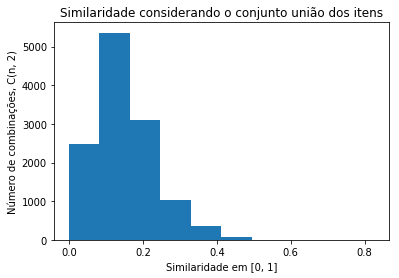

In [18]:
plt.hist(similarities)
plt.title('Similaridade considerando o conjunto união dos itens')
plt.xlabel('Similaridade em [0, 1]')
plt.ylabel('Número de combinações, C(n, 2)')
plt.show()

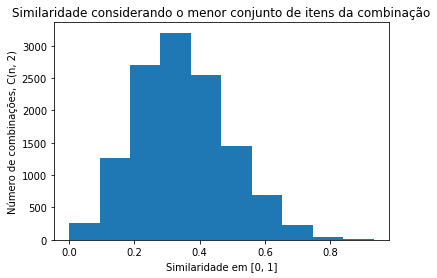

In [19]:
plt.hist(similarities_min)
plt.title('Similaridade considerando o menor conjunto de itens da combinação')
plt.xlabel('Similaridade em [0, 1]')
plt.ylabel('Número de combinações, C(n, 2)')
plt.show()

### Conclusões

Em relação a Métrica 1 (`#(A & B) / #(A | B)`) definida para negar/confirmar a hipótese de que projetos de mesma área e segmento possuem projetos itens similares, podemos concluir que a hipótese foi negada. Pelo menos 75% dos projetos possuem uma similaridade menor que `0.25`, valor menor que o mínimo `0.5` determinado para a hipótese ser confirmada. A maior similaridade encontrada foi de `0.46` de acordo com esta métrica. É possível que as categorias de (Àrea, segmento) não representem adequadamente o que de fato os projetos precisam de itens para executar na prática do projeto, tornando inviável considerar unicamente estas duas variáveis para entender a categoria real de um projeto.

#### Contribuições futuras

A métrica aqui utilizada considera o conjunto de todos os itens de um projeto. Pode ser que considerar itens apenas "significativos" representem melhor a similaridade real dos projetos. As métricas foram calculadas utilizando as labels supervisionadas (oriundas do próprio Salic), pode ser que uma abordagem não-supervisionada atinga resultados melhores sobre esta mesma métrica.